In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from Bayesian_SIR import Bayesian_SIR
import pandas as pd
from pysmooth import smooth
import csv
plt.rcParams['font.size'] = 15

### Parameter initialization

In [2]:
N = 1_000_000
T = 101
I0 = 50

betas = 25*[0.3]+25*[.4]+25*[.25]+26*[.2]
gammas = 25*[0.05]+25*[.15]+25*[.2]+26*[.25]

SIR_model = Bayesian_SIR([N, T, I0], betas, gammas)

### Simulation

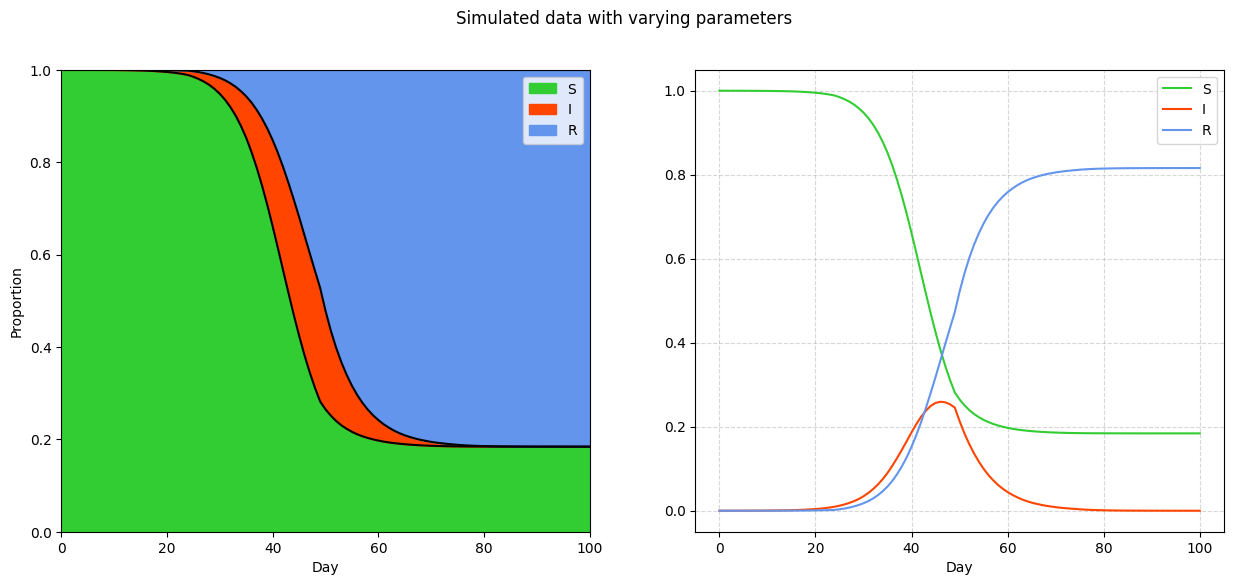

In [3]:
SIR_model.simulation()

## Full run on simulated data

In [4]:
n_steps = 25_000
p = 0.01
T = T - 1
burnin = 5_000
thin = 10

SIR_model.run(p, n_steps, burnin, thin)

Updating beta, gamma and delta parameters...


Buffering...:   0%|          | 0/25000 [00:00<?, ?it/s]

## Bayesian estimators

In [5]:
deltas_samples = SIR_model.deltas_samples
bs_samples = SIR_model.bs_samples
rs_samples = SIR_model.rs_samples
betas_samples = SIR_model.betas_samples
gammas_samples = SIR_model.gammas_samples

In [6]:
betas_mean = np.mean(betas_samples, axis=1)
betas_mean.reshape(4, 25).mean(axis=1)

array([0.31718235, 0.39473399, 0.24831686, 0.21875271])

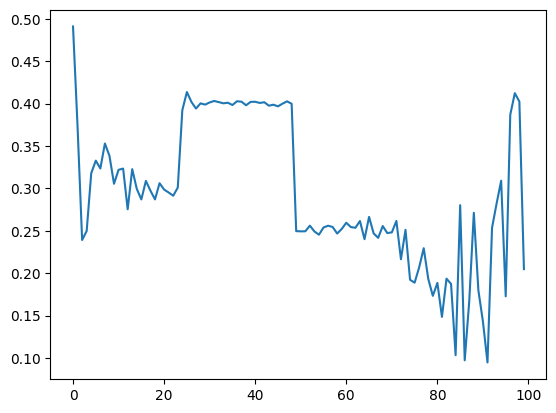

In [7]:
plt.plot(betas_mean)

## Find Bayes estimator $\hat{\delta}$

In [8]:
SIR_model.find_Bayes_delta()
delta_final = SIR_model.delta_final

Finding best delta minimizing the loss...


Loading...:   0%|          | 0/100 [00:00<?, ?it/s]

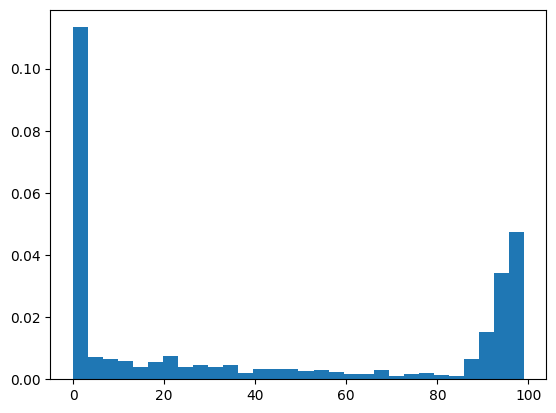

In [9]:
where = np.where(deltas_samples == 1)[0]
plt.hist(where, bins = 30, density=True);

In [10]:
delta_final

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [11]:
np.where(delta_final == 1)[0]

array([ 0,  4, 94], dtype=int64)

In [12]:
SIR_model.ARI(delta_final, np.array(([1]+[0]*24)*4))

0.015882712278555675

In [13]:
SIR_model.MI(delta_final, np.array(([1]+[0]*24)*4))

0.0936435292614487

In [14]:
SIR_model_real = Bayesian_SIR([None]*3, [], [])
data = pd.read_csv('Singapore_new.csv')

# Smooth variables:
data["New_Recovered"] = smooth(x=data["New_Recovered"], kind="3RS3R", twiceit=False, endrule="Tukey")
data["New_Infectious"] = smooth(x=data["New_Infectious"], kind="3RS3R", twiceit=False, endrule="Tukey")

data.to_csv('Singapore_new_smoothed.csv')

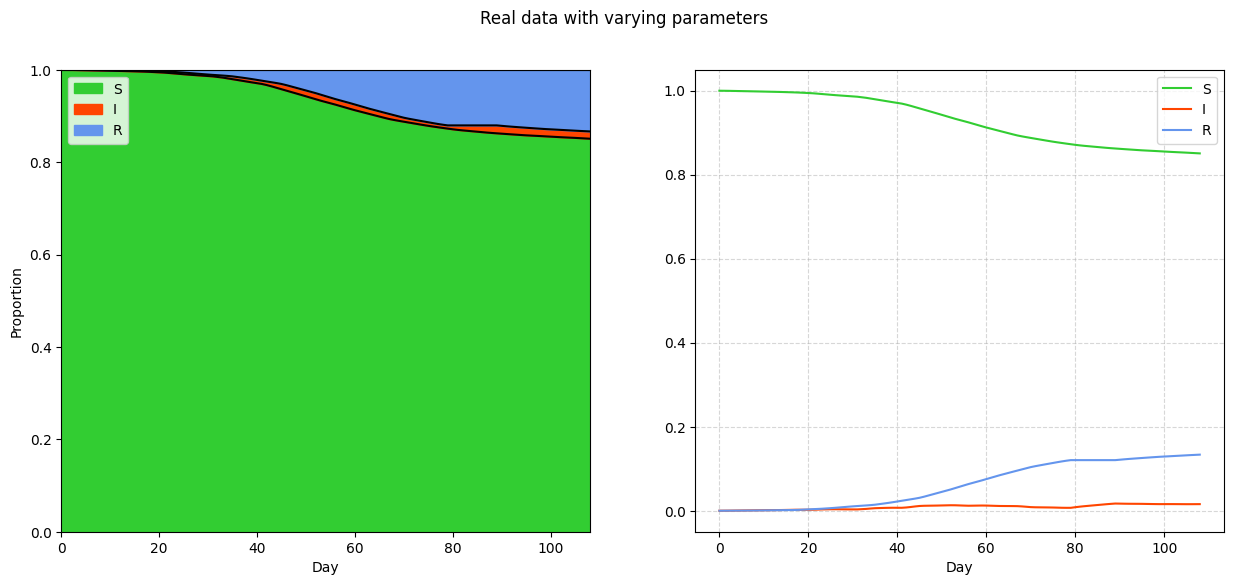

Updating beta, gamma and delta parameters...


Buffering...:   0%|          | 0/25000 [00:00<?, ?it/s]

In [15]:
n_steps = 25_000
p = 0.01
T = T - 1
burnin = 5_000
thin = 10

SIR_model_real.run(p, n_steps, burnin, thin, data_file='Singapore_new_smoothed.csv')

In [16]:
deltas_samples_real = SIR_model_real.deltas_samples
bs_samples_real = SIR_model_real.bs_samples
rs_samples_real = SIR_model_real.rs_samples
betas_samples_real = SIR_model_real.betas_samples
gammas_samples_real = SIR_model_real.gammas_samples

## Comparison between fitted $\beta$ and those provided:

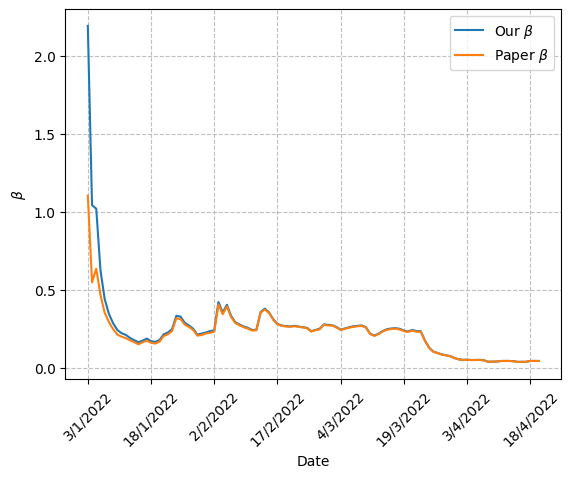

In [35]:
betas_samples_real_mean = np.mean(betas_samples_real, axis=1)
with open('Beta_all.csv', 'r') as f:
    reader = csv.reader(f)
    their_beta = list(reader)
their_beta = np.array(their_beta[1:], dtype=np.double).mean(axis=0)
plt.plot(betas_samples_real_mean, label=r'Our $\beta$')
plt.plot(their_beta, label=r'Paper $\beta$')
plt.xlabel('Date')
plt.xticks(range(0, 109, 15), np.array(data.Date[::15]), rotation=45)
plt.ylabel(r'$\beta$')
plt.grid(ls='--', alpha=0.8)
plt.legend()
plt.show()

## Comparison between fitted $\gamma$ and those provided:

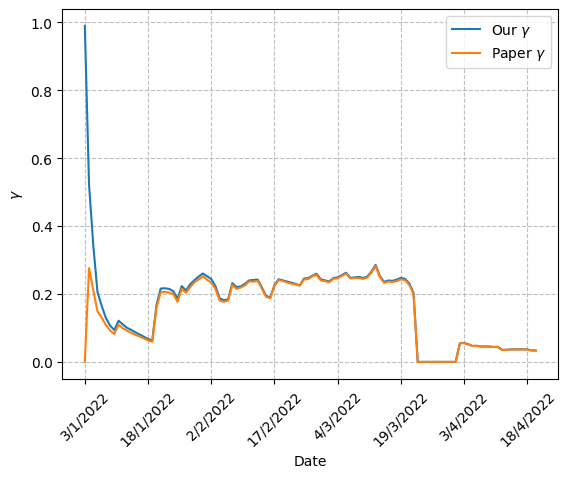

In [37]:
gammas_samples_real_mean = np.mean(gammas_samples_real, axis=1)
with open('Gamma_all.csv', 'r') as f:
    reader = csv.reader(f)
    their_gamma = list(reader)
their_gamma = np.array(their_gamma[1:], dtype=np.double).mean(axis=0)
plt.plot(gammas_samples_real_mean, label=r'Our $\gamma$')
plt.plot(their_gamma, label=r'Paper $\gamma$')
plt.xlabel('Date')
plt.xticks(range(0, 109, 15), np.array(data.Date[::15]), rotation=45)
plt.ylabel(r'$\gamma$')
plt.grid(ls='--', alpha=0.8)
plt.legend()
plt.show()

## Comparison between fitted $\delta$ and those provided:

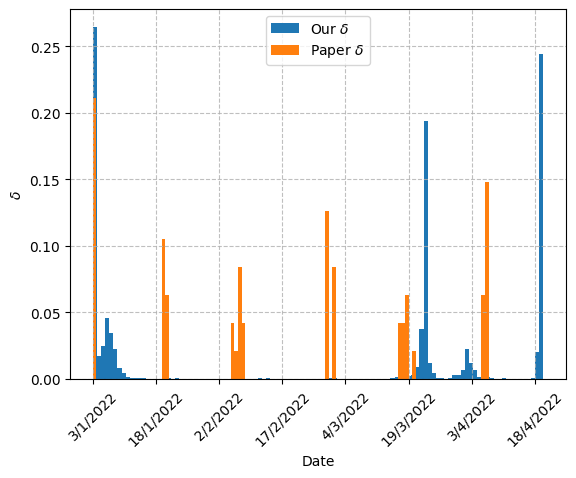

In [45]:
where = np.where(deltas_samples_real == 1)[0]
with open('Delta_all.csv', 'r') as f:
    reader = csv.reader(f)
    their_delta = list(reader)
their_delta = np.array(their_delta[1:], dtype=int).T
where_their = np.where(their_delta == 1)[0]
plt.hist(where, bins = 109, density=True, label=r'Our $\delta$')
plt.hist(where_their, bins = 109, density=True, label=r'Paper $\delta$')
plt.xlabel('Date')
plt.xticks(range(0, 109, 15), np.array(data.Date[::15]), rotation=45)
plt.ylabel(r'$\delta$')
plt.grid(ls='--', alpha=0.8)
plt.legend()
plt.show()

In [18]:
SIR_model_real.find_Bayes_delta()
delta_final_real = SIR_model.delta_final
delta_final_real

Finding best delta minimizing the loss...


Loading...:   0%|          | 0/100 [00:00<?, ?it/s]

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [20]:
np.where(delta_final_real == 1)[0]

array([ 0,  4, 94], dtype=int64)

In [21]:
with open('Delta_all.csv', 'r') as f:
    reader = csv.reader(f)
    loro = list(reader)
loro = np.array(loro[1:], dtype=np.double)

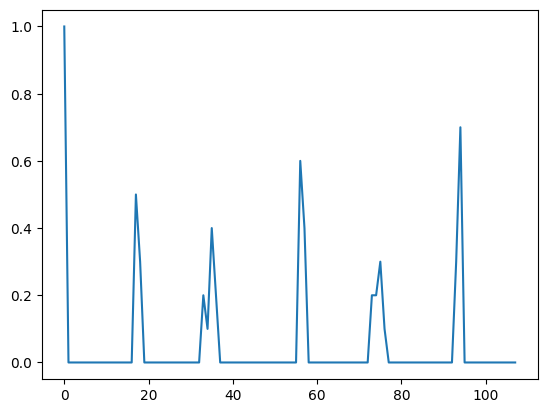

In [22]:
loro_mean = np.mean(loro, axis=0)
plt.plot(loro_mean);

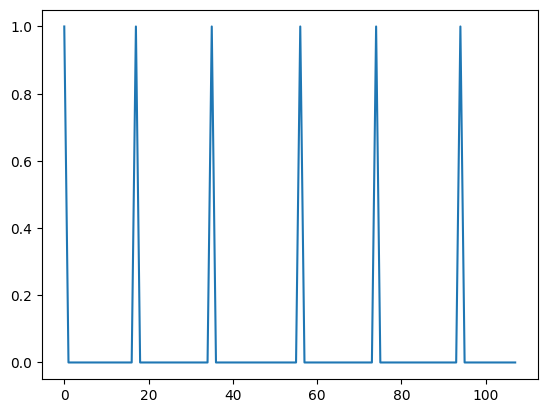

In [23]:
plt.plot(loro[5, :]);